In [46]:
import numpy as np
import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import pandas as pd
import glob
from PIL import Image
import random
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

In [47]:
image_paths1 = glob.glob('/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/images/*.png', recursive=True)
image_paths2 = glob.glob('/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/*.png', recursive=True)
image_paths3 = glob.glob('/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/*.png', recursive=True)
mask_paths1 = glob.glob('/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/masks/*.png', recursive=True)
mask_paths2 = glob.glob('/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks/*.png', recursive=True)
mask_paths3 = glob.glob('/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/masks/*.png', recursive=True)

random.Random(0).shuffle(image_paths1)
random.Random(0).shuffle(image_paths2)
random.Random(0).shuffle(image_paths3)
random.Random(0).shuffle(mask_paths1)
random.Random(0).shuffle(mask_paths2)
random.Random(0).shuffle(mask_paths3)

train_mask_paths1 = mask_paths1[0: int(len(mask_paths1) * 0.9)]
train_image_paths1 = image_paths1[0: int(len(image_paths1) * 0.9)]
val_mask_paths1 = mask_paths1[int(len(mask_paths1) * 0.9): ]
val_image_paths1 = image_paths1[int(len(image_paths1) * 0.9): ]

train_mask_paths2 = mask_paths2[0: int(len(mask_paths2) * 0.9)]
train_image_paths2 = image_paths2[0: int(len(image_paths2) * 0.9)]
val_mask_paths2 = mask_paths2[int(len(mask_paths2) * 0.9): ]
val_image_paths2 = image_paths2[int(len(image_paths2) * 0.9): ]

train_mask_paths3 = mask_paths3[0: int(len(mask_paths3) * 0.9)]
train_image_paths3 = image_paths3[0: int(len(image_paths3) * 0.9)]
val_mask_paths3 = mask_paths3[int(len(mask_paths3) * 0.9): ]
val_image_paths3 = image_paths3[int(len(image_paths3) * 0.9): ]

train_image_paths = train_image_paths1 + train_image_paths2 + train_image_paths3
train_mask_paths = train_mask_paths1 + train_mask_paths2 + train_mask_paths3
val_image_paths = val_image_paths1 + val_image_paths2 + val_image_paths3
val_mask_paths = val_mask_paths1 + val_mask_paths2 + val_mask_paths3

In [48]:
class SegmentationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = smp.Unet(encoder_name="timm-mobilenetv3_large_100", in_channels=3, classes=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.unet(x)
        x = self.sigmoid(x)
        return x

In [49]:
class MyDataset(data.Dataset):
    def __init__(self, image_paths, mask_paths):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def transform(self, image, mask):
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(256, 256))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        return (image, mask)
        
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        mask = Image.open(self.mask_paths[index]).convert('L')
        image, mask = self.transform(image, mask)
        
        return (image, mask)

    def __len__(self):
        return len(self.mask_paths)

In [50]:
class Dice(nn.Module):
    def __init__(self, eps=0):
        super().__init__()
        self.eps = eps

    def forward(self, pred, y_true):
        intersection = 2.0 * torch.sum(pred * y_true) + self.eps
        union = torch.sum(y_true + pred) + self.eps
        return intersection / union

In [51]:
loss_func = nn.BCELoss()
dice_loss = Dice(eps=1e-8)
batch_size = 30
learning_rate = 0.001
num_epochs = 3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SegmentationNet()
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
train_dataset = MyDataset(train_image_paths, train_mask_paths)
val_dataset = MyDataset(val_image_paths, val_mask_paths)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [52]:
for epoch in range(1, num_epochs + 1):
    print('epoch:', epoch)
    model.train()
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        preds = model(images)
        loss = 1 - dice_loss(preds, masks) + loss_func(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval() 
    with torch.no_grad():
        for mode, loader in zip(['train', 'val'], [train_loader, val_loader]):
            epoch_dice, epoch_loss, num_samples = 0, 0, 0
            for images, masks in loader:
                images = images.to(device)
                masks = masks.to(device)
                preds = model(images)
                loss = loss_func(preds, masks)
                preds[preds >= 0.5] = 1.0
                preds[preds < 0.5] = 0.0
                dice = dice_loss(preds, masks)
                epoch_loss += loss.item() * masks.shape[0] 
                epoch_dice += dice.item() * masks.shape[0] 
                num_samples += masks.shape[0]

            epoch_loss = epoch_loss / num_samples
            epoch_dice = epoch_dice / num_samples
            print(mode, '- loss:', f'{epoch_loss:.2}')
            print(mode, '- dice:', f'{epoch_dice:.2}')

epoch: 1
train - loss: 0.17
train - dice: 0.9
val - loss: 0.19
val - dice: 0.9
epoch: 2
train - loss: 0.15
train - dice: 0.91
val - loss: 0.14
val - dice: 0.93
epoch: 3
train - loss: 0.13
train - dice: 0.91
val - loss: 0.15
val - dice: 0.92
epoch: 4
train - loss: 0.23
train - dice: 0.91
val - loss: 0.34
val - dice: 0.91
epoch: 5
train - loss: 0.13
train - dice: 0.92
val - loss: 0.15
val - dice: 0.92


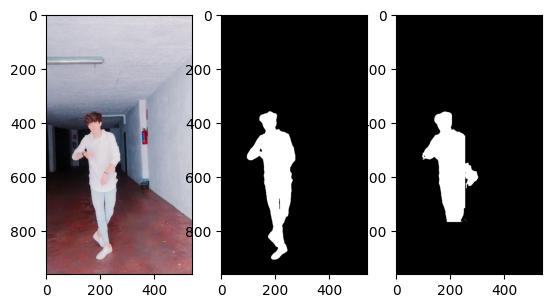

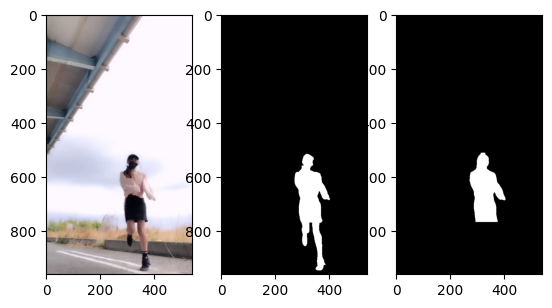

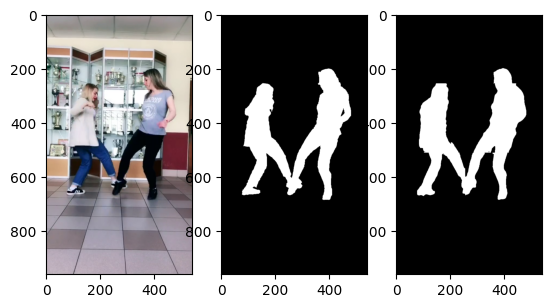

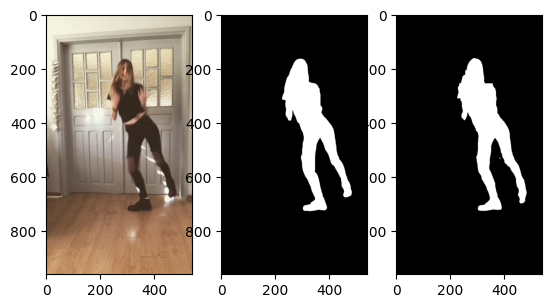

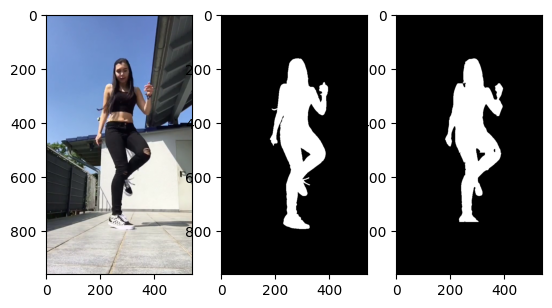

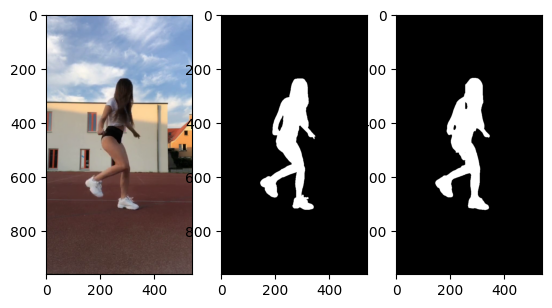

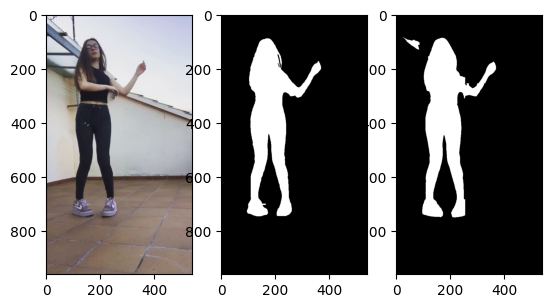

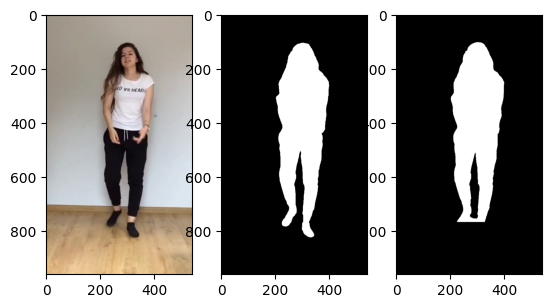

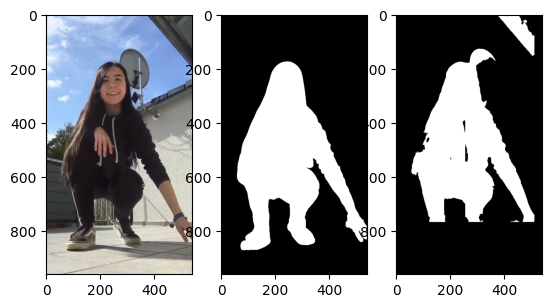

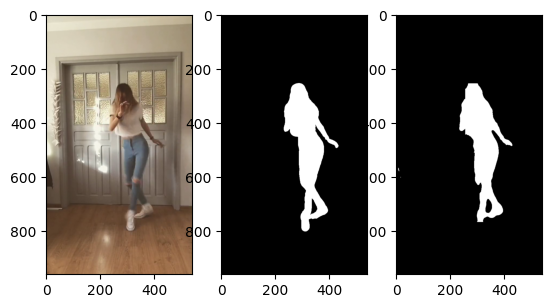

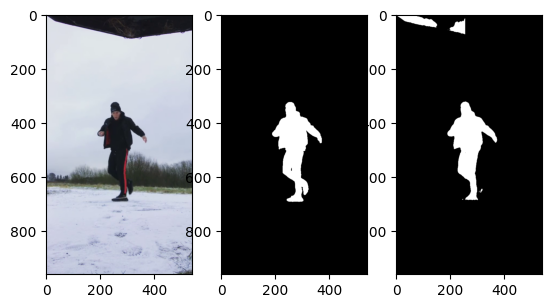

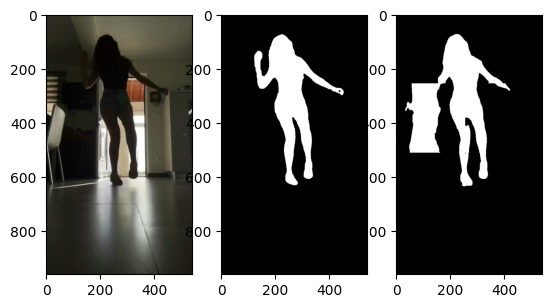

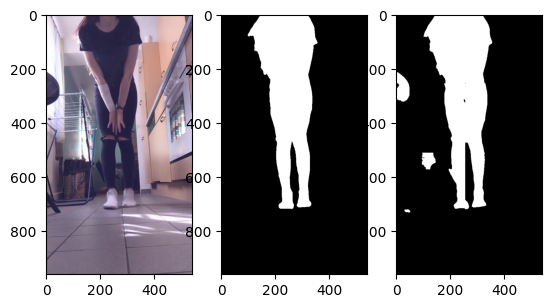

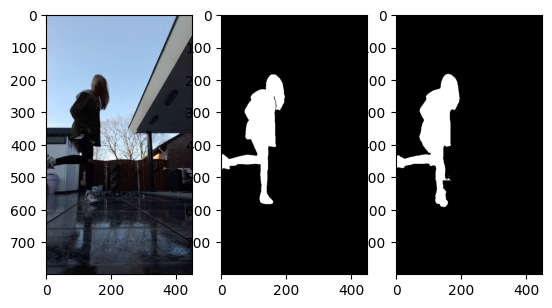

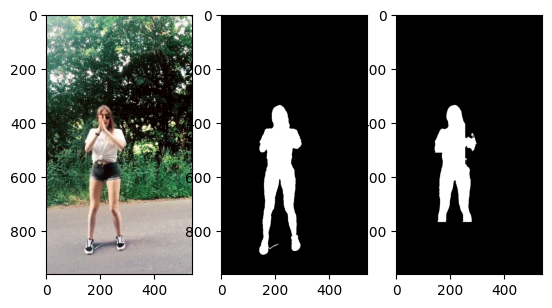

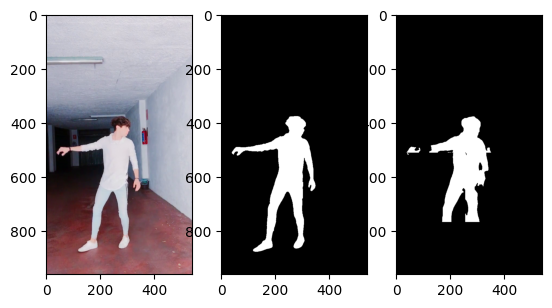

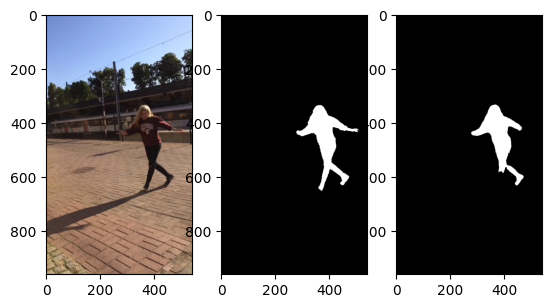

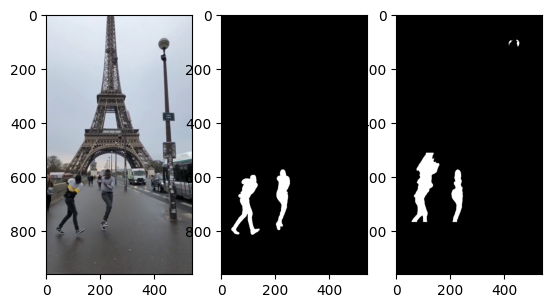

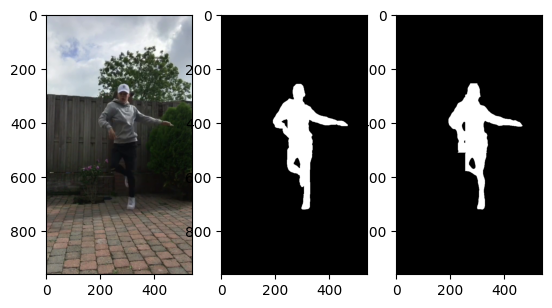

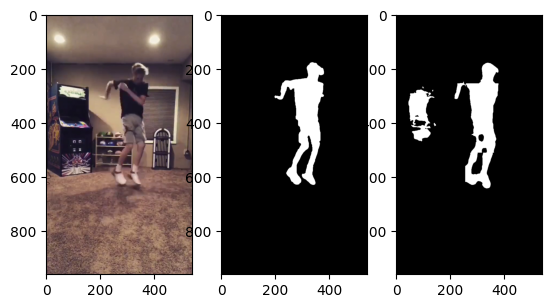

In [53]:
model.eval()
with torch.no_grad():
    for image_path, mask_path in zip(val_image_paths[0: 20], val_mask_paths[0: 20]):
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        image = transforms.ToTensor()(image).unsqueeze(0)
        mask = transforms.ToTensor()(mask).unsqueeze(0)
        _, _, h, w = image.shape
        n_h = h // 256
        n_w = w // 256
        pred = torch.zeros((1, 1, h, w))
        for i in range(n_h):
            for j in range(n_w):
                start_h = i * 256
                end_h = start_h + 256
                start_w = j * 256
                end_w = start_w + 256
                cropped_image = image[:, :, start_h: end_h, start_w: end_w]
                cropped_image = cropped_image.to(device)
                cropped_pred = model(cropped_image)
                pred[:, :, start_h: end_h, start_w: end_w] = cropped_pred

        pred[pred >= 0.5] = 1.0
        pred[pred < 0.5] = 0.0
        fig, axs = plt.subplots(1, 3)
        axs[0].imshow(image.permute(0, 2, 3, 1)[0].detach().cpu().numpy())
        axs[1].imshow(mask.permute(0, 2, 3, 1)[0].detach().cpu().numpy(), cmap='gray')
        axs[2].imshow(pred.permute(0, 2, 3, 1)[0].detach().cpu().numpy(), cmap='gray')
        plt.show()